## Second set of test runs - basic simulations, sparse fields where there is a mismeasurement of the PSFs (in terms of FWHM/shape/sigma).

Let's keep increasing the mismeasurement (percentage-wise) until we break ZOGY.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

24


(0.040776220254577049, 17.126097761280946, -74.0, 1713.7774843356319)
(0.15886556420021791, 17.203687502780589, -82.0, 1131.5017745269811)
(300.04077622025449, 17.126097761280946, 226.0, 2013.7774843356319)
(300.15886556420025, 17.203687502780589, 218.0, 1431.5017745269811)
0.00111178687928


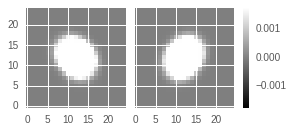

In [4]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.],
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

# Tweak the saved PSFs so the science PSF sigma is slightly wrong ("mis-measured"):
P_n = testObj.im2.psf
testObj.im2.psf = dit.makePsf(psfSize=13, sigma=[2.2,1.8], theta=-35.)

print dit.computeClippedImageStats(testObj.im1.im)
print dit.computeClippedImageStats(testObj.im2.im)
print dit.computeClippedImageStats(testObj.im1.var)
print dit.computeClippedImageStats(testObj.im2.var)

print np.sqrt(((P_n - testObj.im2.psf)**2.).sum())

dit.plotImageGrid((P_n, testObj.im2.psf))

In [5]:
src = testObj.runTest(returnSources=True)

In [6]:
changedCentroid = np.array(testObj.centroids[testObj.changedCentroidInd, :])
print changedCentroid

#print src['AL'][['base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_PsfFlux_fluxSigma', 'base_PsfFlux_flag']]
for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']:
    print key
    if key is not 'SZOGY':
        fsKey = 'base_PsfFlux_fluxSigma'
    else: # For SZOGY, the correct flux measurement is PeakLikelihoodFlux
        fsKey = 'base_PeakLikelihoodFlux_fluxSigma'
    print src[key][['base_NaiveCentroid_x', 'base_NaiveCentroid_y', fsKey, 'base_PsfFlux_flag']]

[[  242.21750369   271.65070471     0.          1500.        ]
 [  278.50448812   278.77794277     0.          1500.        ]
 [  256.96791745   291.09644383     0.          1500.        ]]
ALstack
   base_NaiveCentroid_x  base_NaiveCentroid_y  base_PsfFlux_fluxSigma base_PsfFlux_flag
0            240.889352            271.229726              167.272983             False
1            278.162475            278.045808              168.396500             False
2            256.174951            291.135096              169.907168             False
ZOGY
    base_NaiveCentroid_x  base_NaiveCentroid_y  base_PsfFlux_fluxSigma base_PsfFlux_flag
0             137.085173             43.096588              196.032523             False
1             389.094474             54.072357              228.816185             False
2             376.428993             91.267424              175.361729             False
3             176.051556            137.123835              194.120234             False


In [7]:
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., 
                         varFlux2=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)
testObj.im2.psf = dit.makePsf(psfSize=13, sigma=[2.2,1.8], theta=-35.)

det = testObj.runTest()
print det

{'ZOGY': {'FP': 43, 'FN': 0, 'TP': 8}, 'ALstack': {'FP': 0, 'FN': 0, 'TP': 8}, 'SZOGY': {'FP': 0, 'FN': 0, 'TP': 8}, 'ALstack_noDecorr': {'FP': 0, 'FN': 0, 'TP': 8}}


Try some real tests!

In [19]:
# Default 10 sources with same flux
def runTest(flux, seed=66, sky=300., n_sources=50, n_varSources=1, percentagePsfMismeasure=10.):
    #methods = ['ALstack', 'ZOGY', 'ZOGY_S', 'ALstack_noDecorr']
    testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                             offset=[0,0], psf_yvary_factor=0., 
                             varFlux2=np.repeat(flux, n_varSources),
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(500,30000), seed=seed, psfSize=13)
    #testObj.im2.psf = dit.makePsf(psfSize=13, sigma=[1.9,2.1], theta=-35.)
    ppm = 1.0 + percentagePsfMismeasure / 100.
    origPsf = testObj.im2.psf
    testObj.im2.psf = dit.makePsf(psfSize=13, sigma=[1.8*ppm,2.2*ppm], theta=-45.*ppm)
    det = testObj.runTest() #subtractMethods=methods) #, 'AL'])
    det['flux'] = flux
    det['ppm'] = percentagePsfMismeasure
    det['rms'] = np.sqrt(((origPsf - testObj.im2.psf)**2.).mean())
    #print percentagePsfMismeasure, det['rms']
    return det

methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']

## Look at detection rates for 5.0-sigma sources.

Vary the "error" in PSF measurement from 0 to 20%.

In [20]:
errorVals = [0,1,2,3,4,4.5,5,5.5,6,6.5,7,7.5,8,9,10,12,14,17,20]
inputs = [(f, seed, ppm) for f in [1500] for seed in np.arange(66, 166, 1) for ppm in errorVals]
print len(inputs)
testResults1 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=100, n_varSources=10, \
                                                                      percentagePsfMismeasure=i[2]) \
                                                     for i in inputs)

1900


[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:  1.4min
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:  3.5min
[Parallel(n_jobs=24)]: Done 600 tasks      | elapsed:  6.4min
[Parallel(n_jobs=24)]: Done 965 tasks      | elapsed: 10.2min
[Parallel(n_jobs=24)]: Done 1410 tasks      | elapsed: 14.7min
[Parallel(n_jobs=24)]: Done 1900 out of 1900 | elapsed: 19.4min finished


In [52]:
tr = testResults1
TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})

TP['rms'] = np.array([t['rms'] for t in tr])
FP['rms'] = np.array([t['rms'] for t in tr])
FN['rms'] = np.array([t['rms'] for t in tr])
#sizeme(pd.concat((TP.groupby('ppm').mean(), FP.groupby('ppm').mean()), axis=1))

### Violin plots:
https://seaborn.github.io/generated/seaborn.violinplot.html#seaborn.violinplot

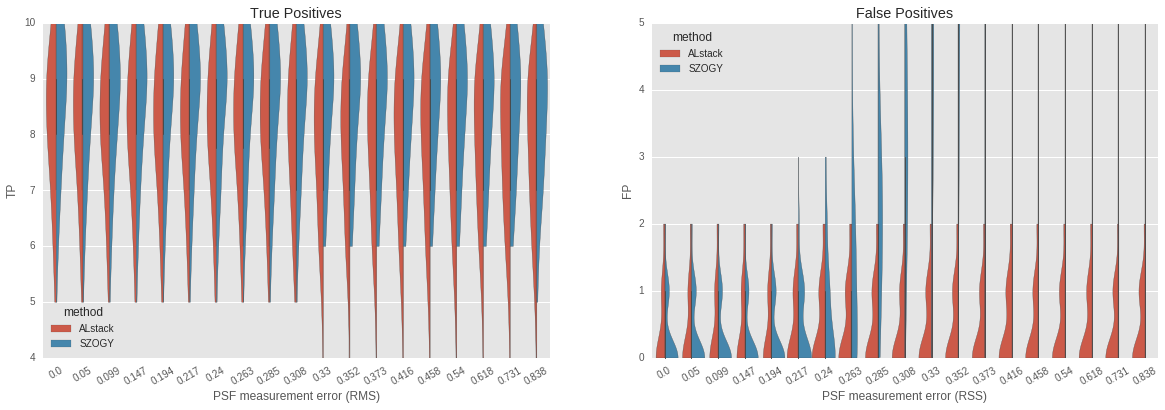

In [53]:
matplotlib.rcParams['figure.figsize'] = (20.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

tmp1 = TP[['rms','ALstack']]
tmp2 = TP[['rms', 'SZOGY']]
tmp1['method'] = np.repeat('ALstack', tmp1.shape[0])
tmp2['method'] = np.repeat('SZOGY', tmp2.shape[0])
tmp1.columns.values[1] = tmp2.columns.values[1] = 'TP'
tmp = pd.concat((tmp1, tmp2))
tmp['rms'] = np.round(tmp['rms'] * 25.**2., 3)  # make it RSS instead of RMS

g = sns.violinplot(x='rms', y='TP', data=tmp, split=True, hue='method', inner="box", cut=0, 
               linewidth=0.3, bw=0.5, ax=axes[0])
g.set_title('True Positives')
g.set_ylim((4, 10))
g.set_xlabel('PSF measurement error (RMS)')
g.set_xticklabels(g.get_xticklabels(), rotation=30);

tmp1 = FP[['rms','ALstack']]
tmp2 = FP[['rms', 'SZOGY']]
tmp1['method'] = np.repeat('ALstack', tmp1.shape[0])
tmp2['method'] = np.repeat('SZOGY', tmp2.shape[0])
tmp1.columns.values[1] = tmp2.columns.values[1] = 'FP'
tmp = pd.concat((tmp1, tmp2))
tmp['rms'] = np.round(tmp['rms'] * 25.**2, 3)

g = sns.violinplot(x='rms', y='FP', data=tmp, split=True, hue='method', inner="box", cut=0, 
               linewidth=0.3, bw=0.5, ax=axes[1], width=0.98)
g.set_title('False Positives')
g.set_ylim((0, 5))
g.set_xlabel('PSF measurement error (RSS)')
g.set_xticklabels(g.get_xticklabels(), rotation=30);

In [51]:
import cPickle
import gzip
cPickle.dump((testResults1), gzip.GzipFile('testResults-copy5.p.gz', 'wb'))

## Look at detection rates for 3.33-sigma sources.

In [42]:
inputs = [(f, seed, ppm) for f in [1000] for seed in np.arange(66, 166, 1) for ppm in errorVals]
print len(inputs)
testResults2 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=100, n_varSources=10, \
                                                                      percentagePsfMismeasure=i[2]) \
                                                     for i in inputs)

1900


[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:  1.5min
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:  3.6min
[Parallel(n_jobs=24)]: Done 600 tasks      | elapsed:  6.5min
[Parallel(n_jobs=24)]: Done 965 tasks      | elapsed:  9.9min
[Parallel(n_jobs=24)]: Done 1410 tasks      | elapsed: 14.2min
[Parallel(n_jobs=24)]: Done 1900 out of 1900 | elapsed: 18.9min finished


In [54]:
tr = testResults2
TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})

TP['rms'] = np.array([t['rms'] for t in tr])
FP['rms'] = np.array([t['rms'] for t in tr])
FN['rms'] = np.array([t['rms'] for t in tr])
#sizeme(pd.concat((TP.groupby('ppm').mean(), FP.groupby('ppm').mean()), axis=1))

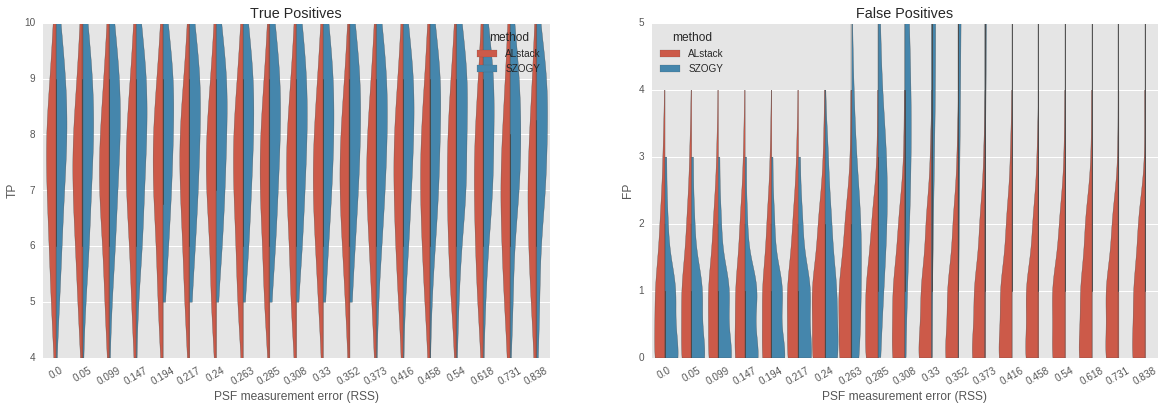

In [55]:
matplotlib.rcParams['figure.figsize'] = (20.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

tmp1 = TP[['rms','ALstack']]
tmp2 = TP[['rms', 'SZOGY']]
tmp1['method'] = np.repeat('ALstack', tmp1.shape[0])
tmp2['method'] = np.repeat('SZOGY', tmp2.shape[0])
tmp1.columns.values[1] = tmp2.columns.values[1] = 'TP'
tmp = pd.concat((tmp1, tmp2))
tmp['rms'] = np.round(tmp['rms'] * 25.**2, 3)

g = sns.violinplot(x='rms', y='TP', data=tmp, split=True, hue='method', inner="box", cut=0, 
               linewidth=0.3, bw=0.5, ax=axes[0])
g.set_title('True Positives')
g.set_ylim((4, 10))
g.set_xlabel('PSF measurement error (RSS)')
g.set_xticklabels(g.get_xticklabels(), rotation=30);

tmp1 = FP[['rms','ALstack']]
tmp2 = FP[['rms', 'SZOGY']]
tmp1['method'] = np.repeat('ALstack', tmp1.shape[0])
tmp2['method'] = np.repeat('SZOGY', tmp2.shape[0])
tmp1.columns.values[1] = tmp2.columns.values[1] = 'FP'
tmp = pd.concat((tmp1, tmp2))
tmp['rms'] = np.round(tmp['rms'] * 25.**2, 3)

g = sns.violinplot(x='rms', y='FP', data=tmp, split=True, hue='method', inner="box", cut=0, 
               linewidth=0.3, bw=0.5, ax=axes[1], width=0.98)
g.set_title('False Positives')
g.set_ylim((0, 5))
g.set_xlabel('PSF measurement error (RSS)')
g.set_xticklabels(g.get_xticklabels(), rotation=30);

In [45]:
cPickle.dump((testResults1, testResults2), gzip.GzipFile('testResults-copy5.p.gz', 'wb'))

## For fun, try some 10-sigma sources.

In [46]:
inputs = [(f, seed, ppm) for f in [3000] for seed in np.arange(66, 166, 1) for ppm in errorVals]
print len(inputs)
testResults3 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=100, n_varSources=10, \
                                                                      percentagePsfMismeasure=i[2]) \
                                                     for i in inputs)

1900


[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:  1.2min
[Parallel(n_jobs=24)]: Done 317 tasks      | elapsed:  3.2min
[Parallel(n_jobs=24)]: Done 600 tasks      | elapsed:  5.9min
[Parallel(n_jobs=24)]: Done 965 tasks      | elapsed:  9.2min
[Parallel(n_jobs=24)]: Done 1410 tasks      | elapsed: 13.4min
[Parallel(n_jobs=24)]: Done 1900 out of 1900 | elapsed: 17.9min finished


In [56]:
tr = testResults3
TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})

TP['rms'] = np.array([t['rms'] for t in tr])
FP['rms'] = np.array([t['rms'] for t in tr])
FN['rms'] = np.array([t['rms'] for t in tr])
#sizeme(pd.concat((TP.groupby('ppm').mean(), FP.groupby('ppm').mean()), axis=1))

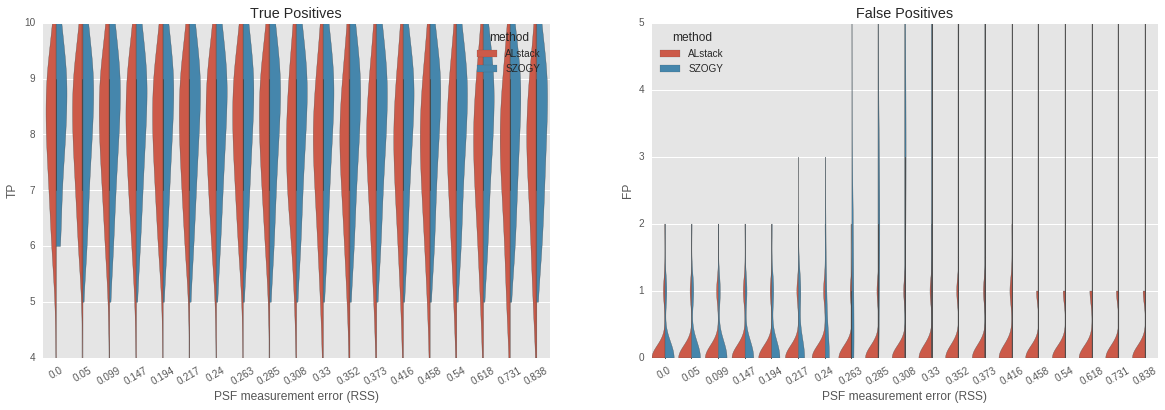

In [57]:
matplotlib.rcParams['figure.figsize'] = (20.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

tmp1 = TP[['rms','ALstack']]
tmp2 = TP[['rms', 'SZOGY']]
tmp1['method'] = np.repeat('ALstack', tmp1.shape[0])
tmp2['method'] = np.repeat('SZOGY', tmp2.shape[0])
tmp1.columns.values[1] = tmp2.columns.values[1] = 'TP'
tmp = pd.concat((tmp1, tmp2))
tmp['rms'] = np.round(tmp['rms'] * 25.**2, 3)

g = sns.violinplot(x='rms', y='TP', data=tmp, split=True, hue='method', inner="box", cut=0, 
               linewidth=0.3, bw=0.5, ax=axes[0])
g.set_title('True Positives')
g.set_ylim((4, 10))
g.set_xlabel('PSF measurement error (RSS)')
g.set_xticklabels(g.get_xticklabels(), rotation=30);

tmp1 = FP[['rms','ALstack']]
tmp2 = FP[['rms', 'SZOGY']]
tmp1['method'] = np.repeat('ALstack', tmp1.shape[0])
tmp2['method'] = np.repeat('SZOGY', tmp2.shape[0])
tmp1.columns.values[1] = tmp2.columns.values[1] = 'FP'
tmp = pd.concat((tmp1, tmp2))
tmp['rms'] = np.round(tmp['rms'] * 25.**2, 3)

g = sns.violinplot(x='rms', y='FP', data=tmp, split=True, hue='method', inner="box", cut=0, 
               linewidth=0.3, bw=0.5, ax=axes[1], width=0.98)
g.set_title('False Positives')
g.set_ylim((0, 5))
g.set_xlabel('PSF measurement error (RSS)')
g.set_xticklabels(g.get_xticklabels(), rotation=30);

In [58]:
cPickle.dump((testResults1, testResults2, testResults3), gzip.GzipFile('testResults-copy5.p.gz', 'wb'))